<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Object Detection using You Only Look Once (YOLO)

![](img/objectdetection.png)

**Notes:** 
- Before running this notebook you will need to download the pre-train Darknet model's weights from [here](https://pjreddie.com/media/files/yolov3.weights) and place the file in the directory `darknet/weights/`
- Since this application uses a pre-trained model, you should be able to run this on your own computer without GPU.  To use the object detection on a webcam output, you will need to run it on your own computer with webcam.

**References**:
- Read the [YOLO v3 paper](https://pjreddie.com/media/files/papers/YOLOv3.pdf)
- This demo notebook uses the pre-trained [Darknet model](https://pjreddie.com/darknet/)
- Some of the code in this notebook is adapted from [this repo](https://github.com/udacity/CVND_Exercises/tree/master/2_2_YOLO)

## Introduction to YOLO

YOLO is a state-of-the-art system for real-time object detection in images which maintains high accuracy while being much faster than most previous types of object detection algorithms.  From the creators of YOLO:  

> "Prior detection systems repurpose classifiers or localizers to perform detection. They apply the model to an image at multiple locations and scales. High scoring regions of the image are considered detections.  We use a totally different approach. We apply a single neural network to the full image. This network divides the image into regions and predicts bounding boxes and probabilities for each region. These bounding boxes are weighted by the predicted probabilities. Our model has several advantages over classifier-based systems. It looks at the whole image at test time so its predictions are informed by global context in the image. It also makes predictions with a single network evaluation unlike systems like R-CNN which require thousands for a single image. This makes it extremely fast, more than 1000x faster than R-CNN and 100x faster than Fast R-CNN."

We will be performing [YOLO v3]((https://pjreddie.com/media/files/papers/YOLOv3.pdf)) in this notebook using the pre-trained [Darknet model](https://pjreddie.com/darknet/), an open source deep neural network architecture developed by the YOLO creators and pre-trained on the Common Objects in Context (COCO) dataset. The `yolov3.cfg` file contains the network architecture for YOLOv3 and the `yolov3.weights` file contains the pre-trained weights.

Because the model we will be using is pre-trained on the COCO dataset, it will only be capable of recognizing objects which are included in the COCO dataset within images.  If we want to be able to recognize additional objects not included in COCO, we need to perform fine-tune training of the model on additional images of the objects we would like to detect.

In [9]:
import time
import cv2
import torch
import matplotlib.pyplot as plt

from utils import plot_boxes, plot_boxes_webcam
from darknet.darknet import Darknet

## Set up

We will be using the latest version of YOLO, known as YOLOv3. We have already downloaded the `yolov3.cfg` file that contains the network architecture used by YOLOv3 and placed it in the `/cfg/` folder. Similarly, we have placed the `yolov3.weights` file that contains the pre-trained weights in the `/weights/` directory. Finally, the `/data/` directory, contains the `coco.names` file that has the list of the 80 object classes that the weights were trained to detect.

In the code below, we start by specifying the location of the files that contain the neural network architecture, the pre-trained weights, and the object classes.  We then use *Darknet* to setup the neural network using the network architecture specified in the `cfg_file`. We then use the`.load_weights()` method to load our set of pre-trained weights into the model. Finally, we use the `load_class_names()` function, from the `utils` module, to load the 80 object classes.

In [10]:
def load_class_names(namesfile):
    # Load the COCO class names
    class_names = []
    with open(namesfile, 'r') as fp:
        lines = fp.readlines()
    for line in lines:
        line = line.rstrip()
        class_names.append(line)
    return class_names

In [11]:
# Set path for the cfg file
cfg_file = './darknet/yolov3.cfg'
# Set path for the pre-trained weights file
weight_file = './darknet/weights/yolov3.weights'
# Set path for the COCO object classes file
namesfile = '../data/coco/coco.names'

# Load the COCO class names
class_names = load_class_names(namesfile)

# Load the network architecture
model = Darknet(cfg_file)

# Load the pre-trained weights
model.load_weights(weight_file)

# Display the YOLOv3 architecture
model.print_network()


layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 

## Load and prepare images

We will use OpenCV's `cv2.imread()` function to load our images. Since this function loads images as BGR we need to convert our images to RGB so we can display them with the correct colors.

As we can see from the YOLO architecture, the input size of the first layer of the network is 416 x 416 x 3. Since our images have different sizes, we have to resize our images to be compatible with the input size of the first layer in the network. In the code below, we resize our images using OpenCV's `cv2.resize()` function.

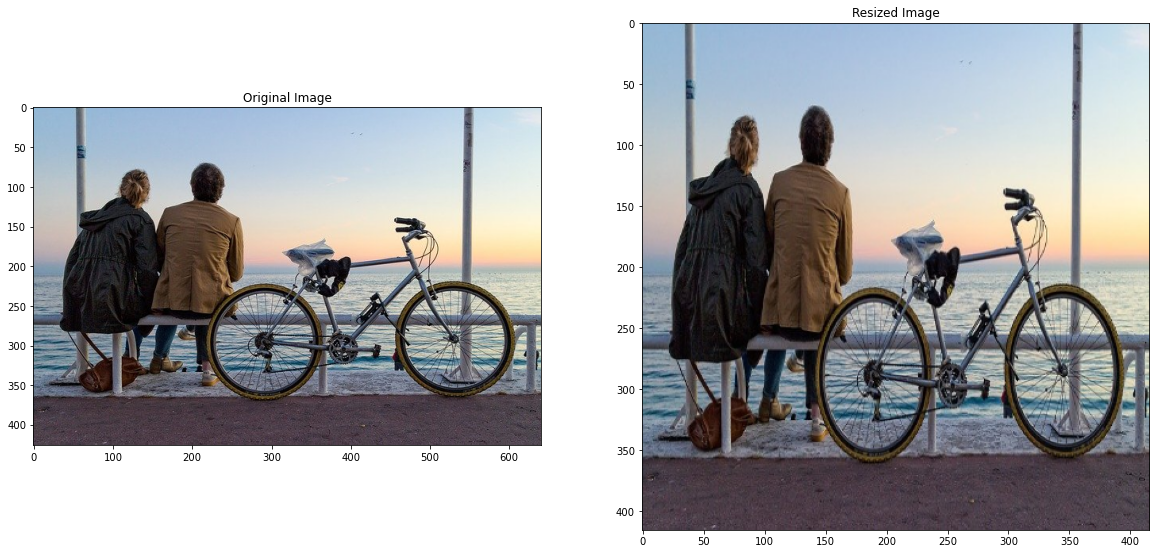

In [12]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [20, 10]

# Load the image
img = cv2.imread('../data/images/bike.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (model.width, model.height))

# Display the images
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

## Detect objects
We can now use the pre-trained Darknet model to detect objects in our image.  The model returns a list of bounding boxes identified in the image, with each box containing seven values: the coordinates *(x, y)* of the center of the bounding box, the width *w* and height *h* of the bounding box, the confidence detection level, the object class probability, and the object class id.

### Non-Maximal Suppression (NMS)

The output from the model includes all bounding boxes identified.  Some of them may be low probability, and some of them may be overlapping.  YOLO uses **Non-Maximal Suppression (NMS)** to only keep the best bounding box and eliminate duplicates. NMS includes two steps:
1) The first step is to remove all the predicted bounding boxes that have a detection probability that is less than the selected NMS threshold. This is done by Darknet for us - we just need to provide the desired detection probability threshold.

2) The second step is to eliminate duplicate bounding boxes which refer to the same object.  We do this by calculating the **Intersection over Union (IOU)** value for each pair of boxes and then eliminate one when the IOU value is above a set threshold.  The box we keep from the pair is the one with the higher detection probability.  The below function `boxes_iou()` calculates the IOU value for a pair of bounding boxes, and the function `nms()` performs the second step of the NMS process on all of the bounding boxes identified by the model to remove duplicates.

In [13]:
def boxes_iou(box1, box2):

    # Get the Width and Height of each bounding box
    width_box1 = box1[2]
    height_box1 = box1[3]
    width_box2 = box2[2]
    height_box2 = box2[3]
    
    # Calculate the area of the each bounding box
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    
    # Find the vertical edges of the union of the two bounding boxes
    mx = min(box1[0] - width_box1/2.0, box2[0] - width_box2/2.0)
    Mx = max(box1[0] + width_box1/2.0, box2[0] + width_box2/2.0)
    
    # Calculate the width of the union of the two bounding boxes
    union_width = Mx - mx
    
    # Find the horizontal edges of the union of the two bounding boxes
    my = min(box1[1] - height_box1/2.0, box2[1] - height_box2/2.0)
    My = max(box1[1] + height_box1/2.0, box2[1] + height_box2/2.0)    
    
    # Calculate the height of the union of the two bounding boxes
    union_height = My - my
    
    # Calculate the width and height of the area of intersection of the two bounding boxes
    intersection_width = width_box1 + width_box2 - union_width
    intersection_height = height_box1 + height_box2 - union_height
   
    # If the the boxes don't overlap then their IOU is zero
    if intersection_width <= 0 or intersection_height <= 0:
        return 0.0

    # Calculate the area of intersection of the two bounding boxes
    intersection_area = intersection_width * intersection_height
    
    # Calculate the area of the union of the two bounding boxes
    union_area = area_box1 + area_box2 - intersection_area
    
    # Calculate the IOU
    iou = intersection_area/union_area
    
    return iou

In [14]:
def nms(boxes, iou_thresh):
    
    # If there are no bounding boxes do nothing
    if len(boxes) == 0:
        return boxes
    
    # Create a PyTorch Tensor to keep track of the detection confidence
    # of each predicted bounding box
    det_confs = torch.zeros(len(boxes))
    
    # Get the detection confidence of each predicted bounding box
    for i in range(len(boxes)):
        det_confs[i] = boxes[i][4]

    # Sort the indices of the bounding boxes by detection confidence value in descending order.
    # We ignore the first returned element since we are only interested in the sorted indices
    _,sortIds = torch.sort(det_confs, descending = True)
    
    # Perform Non-Maximal Suppression 
    best_boxes = []
    for i in range(len(boxes)):
        
        # Get the bounding box with the highest detection confidence first
        box_i = boxes[sortIds[i]]
        
        # Check that the detection confidence is not zero
        if box_i[4] > 0:
            
            # Save the bounding box 
            best_boxes.append(box_i)
            
            # Go through the rest of the bounding boxes in the list and calculate their IOU with
            # respect to the previous selected box_i. 
            for j in range(i + 1, len(boxes)):
                box_j = boxes[sortIds[j]]
                
                # If the IOU of box_i and box_j is higher than the given IOU threshold set
                # box_j's detection confidence to zero. 
                if boxes_iou(box_i, box_j) > iou_thresh:
                    box_j[4] = 0
                    
    return best_boxes

The `detect_objects()` function below will use the Darknet model to detect all objects in the image, and then perform NMS to remove low-probability boxes and duplicates.

In [15]:
def detect_objects(model, img, iou_thresh, nms_thresh):
    
    # Start the time. This is done to calculate how long the detection takes
    start = time.time()
    
    # Set the model to evaluation mode
    model.eval()
    
    # Convert the image from a NumPy ndarray to a PyTorch Tensor of the correct shape
    # The image is transposed, then converted to a FloatTensor of dtype float32, then
    # normalized to values between 0 and 1, and finally unsqueezed to have the correct
    # shape of 1 x 3 x 416 x 416
    img = torch.from_numpy(img.transpose(2,0,1)).float().div(255.0).unsqueeze(0)
    
    # Feed the image to the neural network with the corresponding NMS threshold
    # The first step in NMS is to remove all bounding boxes that have a very low
    # probability of detection. All predicted bounding boxes with a value less than
    # the given NMS threshold will be removed.
    list_boxes = model(img, nms_thresh)
    
    # Make a new list with all the bounding boxes returned by the neural network
    boxes = list_boxes[0][0] + list_boxes[1][0] + list_boxes[2][0]
    
    # Perform NMS step 2 on the boxes returned from the model to remove duplicates
    boxes = nms(boxes, iou_thresh)
    
    # Stop the time. 
    finish = time.time()
    
    # Print the time it took to detect objects
    # Comment this out when detecting objects with webcam
    #print('\n\nIt took {:.3f}'.format(finish - start), 'seconds to detect the objects in the image.\n')
    
    return boxes

Objects found and confidence levels:

1. bicycle: 0.999880
2. person: 1.000000
3. person: 0.999992


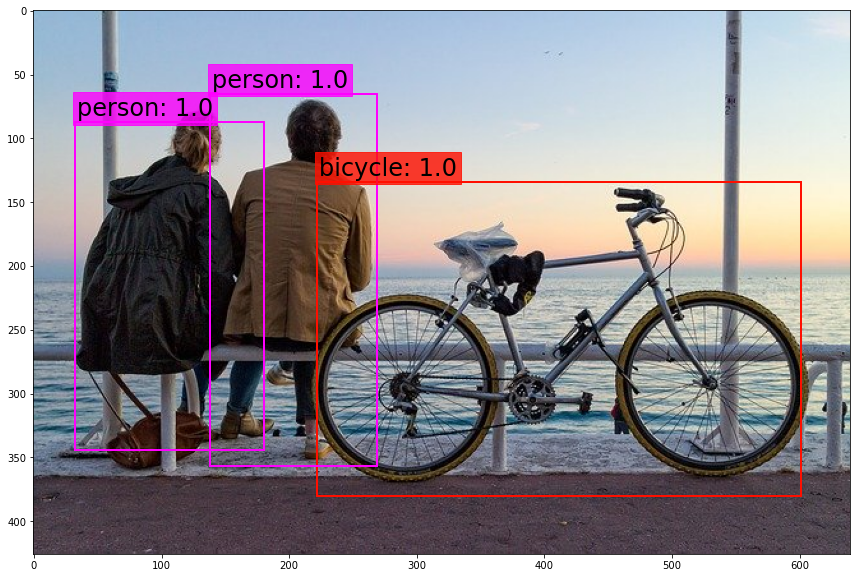

In [16]:
# Set the NMS threshold.  You can adjust this to see what works best
nms_thresh = 0.2

# Set the IOU threshold. You can adjust this to see what works best
iou_thresh = 0.4

# Detect objects in the image
boxes = detect_objects(model, resized_image, iou_thresh, nms_thresh)

# Print the objects found and the confidence level
print('Objects found and confidence levels:\n')
for i in range(len(boxes)):
    box = boxes[i]
    if len(box) == 7 and class_names:
        cls_conf = box[5]
        cls_id = box[6]
        print('%i. %s: %f' % (i + 1, class_names[cls_id], cls_conf))

#Use helper function from utils to plot the image with bounding boxes and corresponding object class labels
plot_boxes(original_image, boxes, class_names, plot_labels = True)

## Run object detection on snapshot from webcam
Running the below cell will open your webcam using OpenCV and display it on the screen.  Hit the `q` key to take a snapshot and stop the webcam.  Then, run the following cell to run the Darknet model on your image and display the identified objects using our above functions.

NOTE: You will need to run this from your own computer, not on a VM on a server, since it uses your computer's webcam

In [40]:
# Open webcam
cap = cv2.VideoCapture(0)

while(True):
    # Display the output from your webcam on screen
    ret, frame = cap.read()
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2BGRA)
    cv2.imshow('frame', rgb)

    # Capture still snapshot when q key is hit and save
    if cv2.waitKey(1) & 0xFF == ord('q'):
        out = cv2.imwrite('../data/images/webcam_capture.jpg', frame)
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

Objects found and confidence levels:

1. person: 1.000000
2. pottedplant: 1.000000


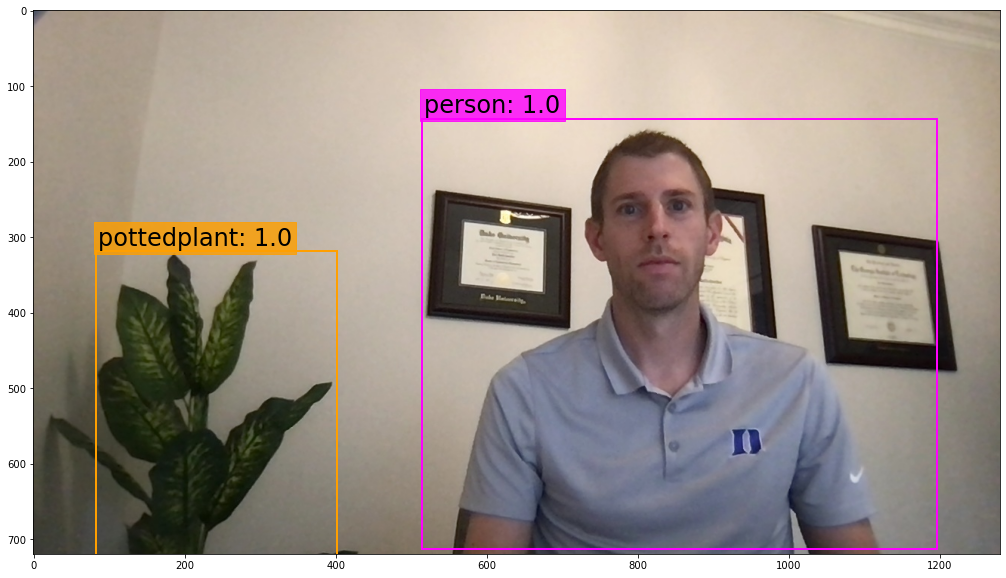

In [41]:
# Load the image
img = cv2.imread('../data/images/webcam_capture.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (model.width, model.height))

# Set the IOU threshold. Default value is 0.4
iou_thresh = 0.4

# Set the NMS threshold. Default value is 0.6
nms_thresh = 0.6

# Detect objects in the image
boxes = detect_objects(model, resized_image, iou_thresh, nms_thresh)

# Print the objects found and the confidence level
print('Objects found and confidence levels:\n')
for i in range(len(boxes)):
    box = boxes[i]
    if len(box) == 7 and class_names:
        cls_conf = box[5]
        cls_id = box[6]
        print('%i. %s: %f' % (i + 1, class_names[cls_id], cls_conf))

#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(original_image, boxes, class_names, plot_labels = True)

# Use webcam feed to detect objects in real-time
We can also run object detection in real-time on streaming video e.g. from our webcam.  Run the below cell to start your webcam and then run object detection using Darknet and our above functions on the frames from your webcam video.  Hit the `q` key to stop.

NOTE: You will need to run this from your own computer, not on a VM on a server, since it uses your computer's webcam

In [39]:
# Open webcam
cap = cv2.VideoCapture(0)

while(True):
    ret, frame = cap.read()
    #rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2BGRA)
    
    # Convert the image to RGB
    original_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Resize the image to the input width and height of the first layer of the Darknet model  
    resized_image = cv2.resize(original_image, (model.width, model.height))

    # Detect objects in the image
    boxes = detect_objects(model, resized_image, iou_thresh, nms_thresh)

    #Plot the image with bounding boxes and corresponding object class labels
    img = plot_boxes_webcam(original_image, boxes, class_names, plot_labels = True)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imshow('Results',rgb_img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1